In [412]:
%pip install arch


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [413]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
# np.random.seed(42)

In [414]:
df = pd.read_excel("../data/RWTCd.xls", sheet_name="Data 1", skiprows=2)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.rename(columns={'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)': 'Price'}, inplace=True)
monthly_df = df.resample('M').last()

/var/folders/rz/rmh6_xns41z59zd1wsh6d8pw0000gn/T/ipykernel_31549/3843705720.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df = df.resample('M').last()


In [415]:
start_date = '2005-12-31'
monthly_df = monthly_df.loc[start_date:]
cutoff_date = '2022-12-31'
train = monthly_df.loc[:cutoff_date]
test = monthly_df.loc[cutoff_date:]
# get safe copy
train = train.copy()
test = test.copy()

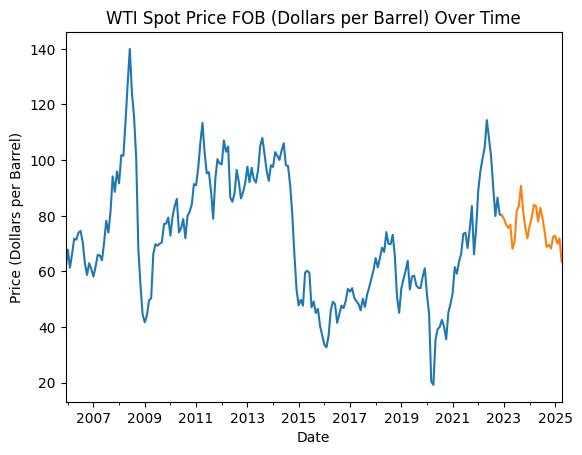

In [416]:
train['Price'].plot()
test['Price'].plot()
plt.title('WTI Spot Price FOB (Dollars per Barrel) Over Time')
plt.xlabel('Date')
plt.ylabel('Price (Dollars per Barrel)')
plt.show()
plt.close()

In [417]:
train['log_return'] = np.log(train['Price']).diff()
train_returns = train['log_return'].dropna()

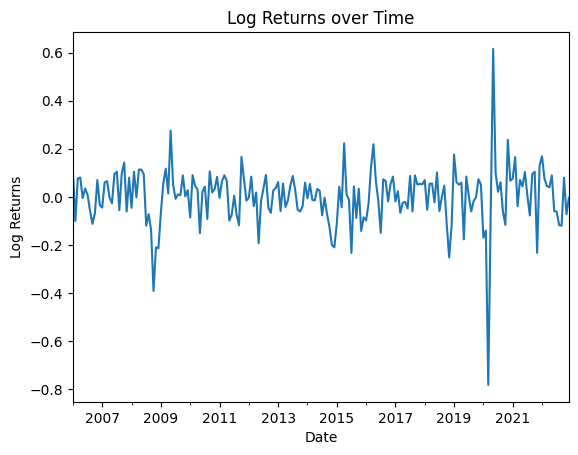

In [418]:
train_returns.plot()
plt.title('Log Returns over Time')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.show()
plt.close()

In [419]:
arima_model = ARIMA(train_returns, order=(1, 0, 1))
arima_prediction = arima_model.fit()
residuals = arima_prediction.resid

In [420]:
garch = arch_model(residuals, vol='Garch', p=1, q=1, rescale=False) # could be unstable
garch_prediction = garch.fit(disp="off")

In [421]:
n_periods = len(test)
num_simulations = 10
arima_forecast = arima_prediction.get_forecast(steps=n_periods)
garch_forecast = garch_prediction.forecast(horizon=n_periods)
forecast_volatility = np.sqrt(garch_forecast.variance.values[-1, :])

In [422]:
last_price = train['Price'].iloc[-1]
simulated_paths = np.zeros((num_simulations, n_periods))

In [423]:
for i in range(num_simulations):
    random_shocks = np.random.normal(0, 1, n_periods)
    random_shocks[0] = 0
    simulated_returns = arima_forecast.predicted_mean.values + forecast_volatility * random_shocks
    simulated_log_prices = np.log(last_price) + np.cumsum(simulated_returns)
    simulated_paths[i, :] = np.exp(simulated_log_prices)

In [424]:
forecasts = pd.date_range(start=pd.to_datetime(cutoff_date) + pd.DateOffset(months=1), periods=n_periods, freq='M')

/var/folders/rz/rmh6_xns41z59zd1wsh6d8pw0000gn/T/ipykernel_31549/1614994024.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecasts = pd.date_range(start=pd.to_datetime(cutoff_date) + pd.DateOffset(months=1), periods=n_periods, freq='M')


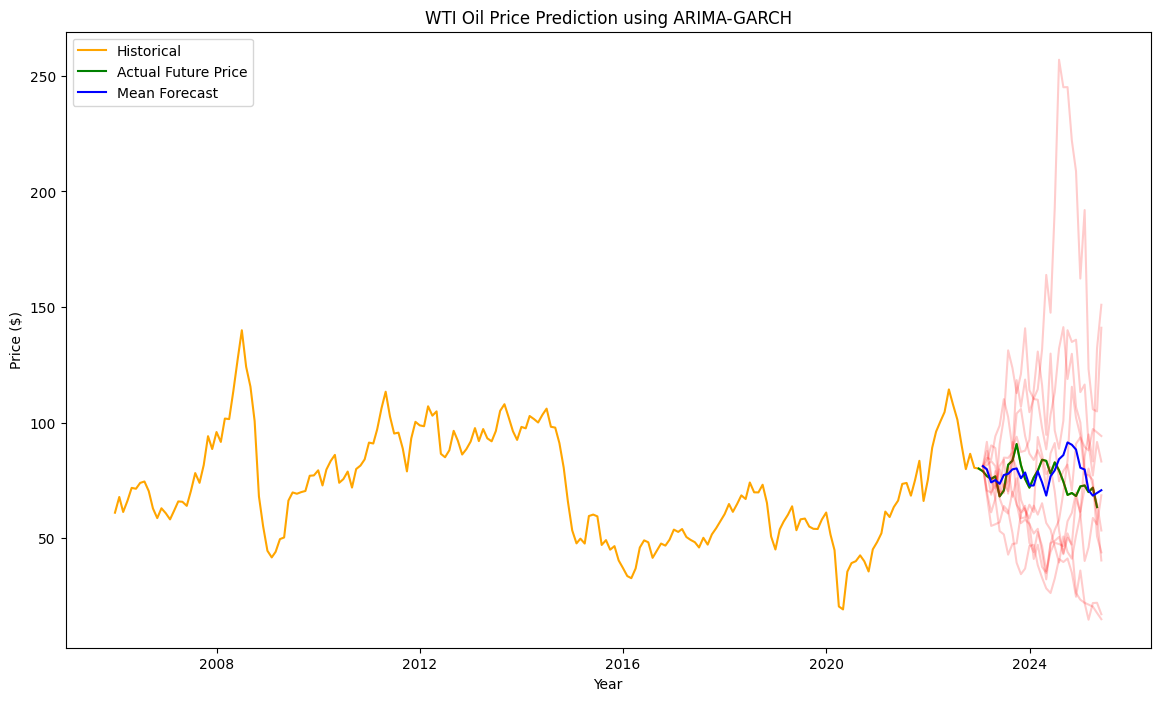

In [426]:
plt.figure(figsize=(14, 8))
plt.plot(monthly_df.index, monthly_df['Price'], label='Historical', color='orange')
plt.plot(test.index, test['Price'], label='Actual Future Price', color='green')
for i in range(num_simulations):
    plt.plot(forecasts, simulated_paths[i], color='red', alpha=0.2)
mean_forecast_path = simulated_paths.mean(axis=0)
plt.plot(forecasts, mean_forecast_path, color='blue', label='Mean Forecast')

plt.title('WTI Oil Price Prediction using ARIMA-GARCH')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.legend()
# plt.grid(True)
plt.show()